---
title: "Project Step II"
subtitle: "Group 11 - Ball by Ball Event Predictor"
date: 10/17/2023
date-modified: last-modified
date-format: long
format:
  html:
    theme: [cosmo, theme.scss]
    toc: true
    embed-resources: true
    number-sections: true
author:
  - name: Tegveer Ghura
    affiliations:
      - id: gu
        name: Georgetown University
        city: Washington
        state: DC
---

# Data Preparation 

## Import the necessary libraries

In [162]:
import random

random.seed(1310)
from seaborn.palettes import color_palette
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import re
import plotly.express as px
import plotly.io as pio

# pio.renderers.default = "notebook"
pio.renderers.default = "plotly_mimetype+notebook_connected"
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import DataConversionWarning

ConvergenceWarning("ignore")
DataConversionWarning("ignore")
from sklearn.model_selection import (
    cross_val_score,
    RepeatedKFold,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    GradientBoostingClassifier,
    BaggingClassifier,
    RandomForestClassifier,
    StackingClassifier,
    AdaBoostClassifier,
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import pickle
import joblib
import json
import sys
import os
import shutil
import warnings

# Load the dataset and display the dataframe 

In [163]:
df = pd.read_csv("data/raw/deliveries.csv", encoding="ISO-8859-1", na_filter=False)

In [164]:
df.head()

,season,match_id,venue,inning,batting_team,bowling_team,batsman,non_striker,bowler,ball,...,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,wickets,commentary
0,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,BB McCullum,P Kumar,0.1,...,0,0,0,1,1,,,,0,"Kumar to Ganguly, 1 leg bye, and thats runs im..."
1,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0.2,...,0,0,0,0,0,,,,0,"Kumar to McCullum, no run, this one nips back ..."
2,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0.3,...,0,0,0,1,1,,,,0,"Kumar to McCullum, 1 wide, thats wide, as Prav..."
3,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0.3,...,0,0,0,0,0,,,,0,"Kumar to McCullum, no run, too straight, McCul..."
4,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0.4,...,0,0,0,0,0,,,,0,"Kumar to McCullum, no run, steps down the trac..."


In [165]:
df.tail()

,season,match_id,venue,inning,batting_team,bowling_team,batsman,non_striker,bowler,ball,...,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,wickets,commentary
131996,2019,final,Hyderabad,2,Chennai Super Kings,Mumbai Indians,RA Jadeja,SR Watson,SL Malinga,19.2,...,0,0,1,0,1,,,,5,"Malinga to Jadeja, 1 run, low full toss on mid..."
131997,2019,final,Hyderabad,2,Chennai Super Kings,Mumbai Indians,SR Watson,RA Jadeja,SL Malinga,19.3,...,0,0,2,0,2,,,,5,"Malinga to Watson, 2 runs, yorker, just outsid..."
131998,2019,final,Hyderabad,2,Chennai Super Kings,Mumbai Indians,SR Watson,RA Jadeja,SL Malinga,19.4,...,0,0,1,0,1,SR Watson,run out,KH Pandya,6,"Malinga to Watson, 1 run, OUT, yorker, just ou..."
131999,2019,final,Hyderabad,2,Chennai Super Kings,Mumbai Indians,SN Thakur,RA Jadeja,SL Malinga,19.5,...,0,0,2,0,2,,,,6,"Malinga to Thakur, 2 runs, full toss on leg, a..."
132000,2019,final,Hyderabad,2,Chennai Super Kings,Mumbai Indians,SN Thakur,RA Jadeja,SL Malinga,19.6,...,0,0,0,0,0,SN Thakur,lbw,,7,"Malinga to Thakur, OUT, Mumbai Indians win IPL..."


In [166]:
df.shape

(132001, 23)

In [167]:
df.columns

Index(['season', 'match_id', 'venue', 'inning', 'batting_team', 'bowling_team',
       'batsman', 'non_striker', 'bowler', 'ball', 'wide_runs', 'bye_runs',
       'legbye_runs', 'noball_runs', 'penalty_runs', 'batsman_runs',
       'extra_runs', 'total_runs', 'player_dismissed', 'dismissal_kind',
       'fielder', 'wickets', 'commentary'],
      dtype='object')

## Check for Missing Values/NAs

In [168]:
df.isna().sum()

season              0
match_id            0
venue               0
inning              0
batting_team        0
bowling_team        0
batsman             0
non_striker         0
bowler              0
ball                0
wide_runs           0
bye_runs            0
legbye_runs         0
noball_runs         0
penalty_runs        0
batsman_runs        0
extra_runs          0
total_runs          0
player_dismissed    0
dismissal_kind      0
fielder             0
wickets             0
commentary          0
dtype: int64

## Remove Unnecessary Columns

In [169]:
columns_to_remove = ["player_dismissed", "fielder", "penalty_runs"]
df.drop(labels=columns_to_remove, axis=1, inplace=True)

In [170]:
df.head()

,season,match_id,venue,inning,batting_team,bowling_team,batsman,non_striker,bowler,ball,wide_runs,bye_runs,legbye_runs,noball_runs,batsman_runs,extra_runs,total_runs,dismissal_kind,wickets,commentary
0,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,BB McCullum,P Kumar,0.1,0,0,1,0,0,1,1,,0,"Kumar to Ganguly, 1 leg bye, and thats runs im..."
1,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0.2,0,0,0,0,0,0,0,,0,"Kumar to McCullum, no run, this one nips back ..."
2,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0.3,1,0,0,0,0,1,1,,0,"Kumar to McCullum, 1 wide, thats wide, as Prav..."
3,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0.3,0,0,0,0,0,0,0,,0,"Kumar to McCullum, no run, too straight, McCul..."
4,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0.4,0,0,0,0,0,0,0,,0,"Kumar to McCullum, no run, steps down the trac..."


## Feature Engineering `bowler_type`

In the code cell below, we have created a custom list of all spin bowlers for each team. We have then modified the `bowler` column in the dataframe which will be used to identify the type of bowler, either "spinner" or "pacer". Therefore, instead of dropping the `bowler` column, we have created a new column `bowler_type` which will be used for our analysis and enhance the predictive power of our models.

In [171]:
# Replacing all spinner names with 'spinner' and all pacer names with 'pacer' under `bowler` column

rcb_spin = [
    "SB Joshi",
    "KP Appanna",
    "A Kumble",
    "J Arunkumar",
    "Abdur Razzak",
    "CL White",
    "TM Dilshan",
    "KP Pietersen",
    "RE van der Merwe",
    "S Sriram",
    "DL Vettori",
    "KB Arun Karthik",
    "CH Gayle",
    "S Sriram",
    "AA Kazi",
    "R Ninan",
    "J Syed Mohammad",
    "M Muralitharan",
    "M Kartik",
    "P R Barman",
    "Sachin Baby",
    "YS Chahal",
    "Yuvraj Singh",
    "SB Jakati",
    "Iqbal Abdulla",
    "T Shamsi",
    "Parvez Rasool",
    "S Baby",
    "TM Head",
    "KM Jadhav",
    "P Negi",
    "S Badree",
    "Washington Sundar",
    "M Ali",
    "M Ashwin",
]

mi_spin = [
    "A Dananjaya",
    "AG Murtaza",
    "A Roy",
    "GJ Maxwell",
    "Harbhajan Singh",
    "J Suchith",
    "J Yadav",
    "JP Duminy",
    "KH Pandya",
    "KV Sharma",
    "M Markande",
    "N Rana",
    "PP Ojha",
    "RD Chahar",
    "RG Sharma",
    "RJ Peterson",
    "RW Price",
    "S Gopal",
    "SD Chitnis",
    "ST Jayasuriya",
    "TL Suman",
    "VS Yeligati",
]

kkr_spin = [
    "BAW Mendis",
    "BJ Hodge",
    "DJ Hussey",
    "GB Hogg",
    "J Botha",
    "KC Cariappa",
    "M Kartik",
    "CH Gayle",
    "Iqbal Abdulla",
    "Kuldeep Yadav",
    "MB Parmar",
    "MK Tiwary",
    "Mohammad Hafeez",
    "N Rana",
    "PP Chawla",
    "RS Gavaskar",
    "S Ladda",
    "Shakib Al Hasan",
    "SMSM Senanayake",
    "SP Narine",
    "YK Pathan",
]

csk_spin = [
    "DJ Hussey",
    "F du Plessis",
    "Harbhajan Singh",
    "Imran Tahir",
    "RA Jadeja",
    "KV Sharma",
    "M Santner",
    "M Muralitharan",
    "P Negi",
    "R Ashwin",
    "S Badree",
    "S Randiv",
    "S Vidyut",
    "SB Jakati",
    "SK Raina",
    "SMSM Senanayake",
]

dc_spin = [
    "A Mishra",
    "AA Jhunjhunwala",
    "Ankit Sharma",
    "CL White",
    "PP Ojha",
    "DB Ravi Teja",
    "JP Duminy",
    "LPC Silva",
    "R Sharma",
    "RG Sharma",
    "S Dhawan",
    "Shahid Afridi",
    "TL Suman",
    "Y Venugopal Rao",
]

dd_spin = [
    "A Mishra",
    "AJ Finch",
    "AR Patel",
    "BMAJ Mendis",
    "DL Vettori",
    "GJ Maxwell",
    "H Vihari",
    "Imran Tahir",
    "J Suchith",
    "J Botha",
    "J Yadav",
    "JP Duminy",
    "KP Pietersen",
    "MK Tiwary",
    "P Negi",
    "R Sharma",
    "R Tewatia",
    "RE van der Merwe",
    "S Ladda",
    "S Lamichhane",
    "S Nadeem",
    "S Sriram",
    "Shoaib Malik",
    "TM Dilshan",
    "Sunny Gupta",
    "V Sehwag",
    "Y Venugopal Rao",
    "Yuvraj Singh",
    "Y Nagar",
]

srh_spin = [
    "A Mishra",
    "Ankit Sharma",
    "Bipul Sharma",
    "CL White",
    "DJ Hooda",
    "KS Williamson",
    "KV Sharma",
    "Mohammad Nabi",
    "Parvez Rasool",
    "Rashid Khan",
    "S Nadeem",
    "Shakib Al Hasan",
    "Y Venugopal Rao",
    "YK Pathan",
    "Yuvraj Singh",
]

rr_spin = [
    "A Chandila",
    "AA Chavan",
    "AA Jhunjhunwala",
    "AC Voges",
    "AJ Finch",
    "AL Menaria",
    "Ankit Sharma",
    "AS Raut",
    "BJ Hodge",
    "D Short",
    "DJ Hooda",
    "D Salunkhe",
    "GB Hogg",
    "I Sodhi",
    "J Botha",
    "K Gowtham",
    "L Livingstone",
    "LRPL Taylor",
    "M Lomror",
    "PV Tambe",
    "ND Doshi",
    "R Parag",
    "R Tewatia",
    "S Badree",
    "S Gopal",
    "RA Jadeja",
    "S Midhun",
    "SK Warne",
    "YK Pathan",
]

punj_spin = [
    "AC Gilchrist",
    "AR Patel",
    "BA Bhatt",
    "Bipul Sharma",
    "DJ Hussey",
    "GJ Maxwell",
    "Gurkeerat Singh" "H Brar",
    "Karanveer Singh",
    "KC Cariappa",
    "M Ashwin",
    "M Kartik",
    "M Ur Rahman",
    "M Vijay",
    "MK Tiwary",
    "P Sahu",
    "PP Chawla",
    "R Ashwin",
    "R Tewatia",
    "RR Powar",
    "Shivam Sharma",
    "SN Khan",
    "Swapnil Singh",
    "V Chakravarthy",
    "Yuvraj Singh",
]

In [172]:
# Replacing all spin bowlers' names with 'spinner' under `bowler` column

df.loc[
    (df.bowling_team == "Royal Challengers Bangalore") & (df.bowler.isin(rcb_spin)),
    "bowler",
] = "spinner"
df.loc[
    (df.bowling_team == "Delhi Capitals") & (df.bowler.isin(dd_spin)), "bowler"
] = "spinner"
df.loc[
    (df.bowling_team == "Delhi Daredevils") & (df.bowler.isin(dd_spin)), "bowler"
] = "spinner"
df.loc[
    (df.bowling_team == "Mumbai Indians") & (df.bowler.isin(mi_spin)), "bowler"
] = "spinner"
df.loc[
    (df.bowling_team == "Chennai Super Kings") & (df.bowler.isin(csk_spin)), "bowler"
] = "spinner"
df.loc[
    (df.bowling_team == "Kings XI Punjab") & (df.bowler.isin(punj_spin)), "bowler"
] = "spinner"
df.loc[
    (df.bowling_team == "Sunrisers Hyderabad") & (df.bowler.isin(srh_spin)), "bowler"
] = "spinner"
df.loc[
    (df.bowling_team == "Kolkata Knight Riders") & (df.bowler.isin(kkr_spin)), "bowler"
] = "spinner"
df.loc[
    (df.bowling_team == "Deccan Chargers") & (df.bowler.isin(dc_spin)), "bowler"
] = "spinner"
df.loc[
    (df.bowling_team == "Rajasthan Royals") & (df.bowler.isin(rr_spin)), "bowler"
] = "spinner"

In [173]:
# Replacing all fast/pace bowlers' names with 'pacer' under `bowler` column

l = ["spinner"]
df.loc[~df.bowler.isin(l), "bowler"] = "pacer"

In [174]:
df.loc[df.bowler == "pacer"]

,season,match_id,venue,inning,batting_team,bowling_team,batsman,non_striker,bowler,ball,wide_runs,bye_runs,legbye_runs,noball_runs,batsman_runs,extra_runs,total_runs,dismissal_kind,wickets,commentary
0,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,BB McCullum,pacer,0.1,0,0,1,0,0,1,1,,0,"Kumar to Ganguly, 1 leg bye, and thats runs im..."
1,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,pacer,0.2,0,0,0,0,0,0,0,,0,"Kumar to McCullum, no run, this one nips back ..."
2,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,pacer,0.3,1,0,0,0,0,1,1,,0,"Kumar to McCullum, 1 wide, thats wide, as Prav..."
3,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,pacer,0.3,0,0,0,0,0,0,0,,0,"Kumar to McCullum, no run, too straight, McCul..."
4,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,pacer,0.4,0,0,0,0,0,0,0,,0,"Kumar to McCullum, no run, steps down the trac..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131996,2019,final,Hyderabad,2,Chennai Super Kings,Mumbai Indians,RA Jadeja,SR Watson,pacer,19.2,0,0,0,0,1,0,1,,5,"Malinga to Jadeja, 1 run, low full toss on mid..."
131997,2019,final,Hyderabad,2,Chennai Super Kings,Mumbai Indians,SR Watson,RA Jadeja,pacer,19.3,0,0,0,0,2,0,2,,5,"Malinga to Watson, 2 runs, yorker, just outsid..."
131998,2019,final,Hyderabad,2,Chennai Super Kings,Mumbai Indians,SR Watson,RA Jadeja,pacer,19.4,0,0,0,0,1,0,1,run out,6,"Malinga to Watson, 1 run, OUT, yorker, just ou..."
131999,2019,final,Hyderabad,2,Chennai Super Kings,Mumbai Indians,SN Thakur,RA Jadeja,pacer,19.5,0,0,0,0,2,0,2,,6,"Malinga to Thakur, 2 runs, full toss on leg, a..."


In [175]:
df.loc[df.bowler == "spinner"]

,season,match_id,venue,inning,batting_team,bowling_team,batsman,non_striker,bowler,ball,wide_runs,bye_runs,legbye_runs,noball_runs,batsman_runs,extra_runs,total_runs,dismissal_kind,wickets,commentary
56,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,RT Ponting,BB McCullum,spinner,9.1,0,0,0,0,1,0,1,,1,"Joshi to Ponting, 1 run, some good turn, spins..."
57,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,RT Ponting,spinner,9.2,0,0,0,0,1,0,1,,1,"Joshi to McCullum, 1 run, too straight and fla..."
58,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,RT Ponting,BB McCullum,spinner,9.3,0,0,0,0,1,0,1,,1,"Joshi to Ponting, 1 run, fired on leg again an..."
59,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,RT Ponting,spinner,9.4,0,0,0,0,0,0,0,,1,"Joshi to McCullum, no run, bit of flight there..."
60,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,RT Ponting,spinner,9.5,0,0,0,0,6,0,6,,1,"Joshi to McCullum, SIX runs, snuff is snuff, s..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131984,2019,final,Hyderabad,2,Chennai Super Kings,Mumbai Indians,SR Watson,DJ Bravo,spinner,17.2,0,0,0,0,6,0,6,,4,"KH Pandya to Watson, SIX runs, hammered! Full,..."
131985,2019,final,Hyderabad,2,Chennai Super Kings,Mumbai Indians,SR Watson,DJ Bravo,spinner,17.3,0,0,0,0,6,0,6,,4,"KH Pandya to Watson, SIX runs, over Krunal's h..."
131986,2019,final,Hyderabad,2,Chennai Super Kings,Mumbai Indians,SR Watson,DJ Bravo,spinner,17.4,0,0,0,0,6,0,6,,4,"KH Pandya to Watson, SIX runs, into the second..."
131987,2019,final,Hyderabad,2,Chennai Super Kings,Mumbai Indians,SR Watson,DJ Bravo,spinner,17.5,0,0,0,0,0,0,0,,4,"KH Pandya to Watson, no run, full, fast, and w..."


In [176]:
# sanity check - check for NaN values in `bowler` column

df.bowler.isna().sum()

0

## Feature Engineering `batsman` and `non_striker` Type

In cricket, the batting order is the sequence in which batters play through their team's innings, there always being two batters taking part at any one time. All eleven players in a team are required to bat if the innings is completed (i.e., if the innings does not close early due to a declaration or other factor).

The batting order is colloquially subdivided into:

1. Top order (batters one to three)
2. Middle order (batters four to eight)
3. Tail enders (batters nine to eleven) 

In the code cell below, we have created a custom list of all top order batsman and tail enders for each team. We have then modified the `batsman` and `non_striker` columns in the dataframe which will be used to identify the type of batsman, "top_order", "middle_order" or "tail_ender". This column, we belive, should lend to the predictive power of our models. For example, a top order batsman is more likely to score a boundary than a tail ender, purely based on batting skill. Moreover, if given the scenario that a top order batsman bats till the last 5 overs of the game with a tail ender at the non-striker's end, the top order batsman is more likely to retain strike to maximize the number of runs scored in the last 5 overs.

We deliberately chose not to take the easier route of engineering these columns column based on the `wickets` column. Doing so would induce multicollinearity in the data and, more importantly, alter the `batsman` and `non_striker` columns in a way that would compromise the integrity of our data.

**Note:** It is not uncommon in cricket that an opening batsman may play in the middle order or vice-versa, given various factors such as recent form of the batsman or captain's/coach's discretion. Therefore, we have categorized individual batters with regards to their ideal batting position. For example, Robin Uthappa started off as a middle order batsman in 2008 with Mumbai Indians, but was promoted to the top order when he joined Royal Challengers Bangalore and Kolkata Knight Riders in 2010 and 2014 respectively.

In [177]:
# Creating a list of all top order batsmen and tail enders for each team

rcb_top_order = [
    "TM Dilshan",
    "KP Pietersen",
    "CH Gayle",
    "PA Patel",
    "V Kohli",
    "AB de Villiers",
    "R Dravid",
    "JH Kallis",
    "MK Pandey",
    "W Jaffer",
    "S Chanderpaul",
    "LRPL Taylor",
    "SR Watson",
    "Mandeep Singh",
    "A Mukund",
    "BB McCullum",
    "CA Pujara",
    "MA Agarwal",
    "KL Rahul",
    "Q de Kock",
    "J Arunkumar",
    "S Sriram",
]

rcb_tail_enders = [
    "SB Joshi",
    "KP Appanna",
    "A Kumble",
    "Abdur Razzak",
    "DL Vettori",
    "KB Arun Karthik",
    "S Sriram",
    "AA Kazi",
    "R Ninan",
    "J Syed Mohammad",
    "M Muralitharan",
    "M Kartik",
    "P R Barman",
    "YS Chahal",
    "SB Jakati",
    "T Shamsi",
    "Parvez Rasool",
    "P Kumar",
    "Z Khan",
    "R Vinay Kumar",
    "DW Steyn",
    "ND Doshi",
    "DP Nannes",
    "JJ van der Wath",
    "S Aravind",
    "S Badree",
    "CK Langeveldt",
    "RR Bhatkal",
    "P Parameswaran",
    "JD Unadkat",
    "RP Singh",
    "R Rampaul",
    "MA Starc",
    "M Ashwin" "AB Dinda",
    "VR Aaron",
    "AN Ahmed",
    "AF Milne",
    "KW Richardson",
    "CJ Jordan",
    "TS Mills",
    "A Choudhary",
    "B Stanlake",
    "Avesh Khan",
    "UT Yadav",
    "K Khejroliya",
    "Mohammed Siraj",
    "TG Southee",
    "N Saini",
]

mi_top_order = [
    "N Rana",
    "RG Sharma",
    "ST Jayasuriya",
    "SR Tendulkar",
    "YV Takawale",
    "AM Rahane",
    "DR Smith",
    "L Ronchi",
    "AC Blizzard",
    "RV Uthappa",
    "AT Rayudu",
    "DJ Jacobs",
    "S Dhawan",
    "SS Tiwary",
    "JP Duminy",
    "AP Tare",
    "AJ Finch",
    "E Lewis",
    "Ishan Kishan",
    "Q de Kock",
    "AM Rahane",
    "LMP Simmons",
    "CM Gautam",
    "C Madan",
    "PA Patel",
    "BR Dunk",
    "JC Buttler",
    "SM Pollock",
    "AS Yadav",
    "HH Gibbs",
    "UBT Chand",
    "GJ Maxwell",
    "MJ Guptill",
    "RE Levi",
]

mi_tail_enders = [
    "A Dananjaya",
    "AG Murtaza",
    "Harbhajan Singh",
    "J Yadav",
    "M Markande",
    "PP Ojha",
    "RD Chahar",
    "RW Price",
    "VS Yeligati",
    "Z Khan",
    "SL Malinga",
    "JJ Bumrah",
    "MG Johnson",
    "P Suyal",
    "A Nehra",
    "DS Kulkarni",
    "MA Khote",
    "CRD Fernando",
    "DJ Thornely",
    "RR Raje",
    "DR Smith",
    "RP Singh",
    "CJ McKay",
    "NLTC Perera",
    "R Shukla",
    "A Nel",
    "Z Khan",
    "R McLaren",
    "AN Ahmed",
    "MM Patel",
    "YS Chahal",
    "P Kumar",
    "K Santokie",
    "M de Lange",
    "R Vinay Kumar",
    "MJ McClenaghan",
    "TG Southee",
    "Mustafizur Rahman",
    "PJ Sangwan",
    "R Salam",
    "J Behrendorff",
    "A Joseph",
    "BB Sran",
]

kkr_top_order = [
    "SC Ganguly",
    "BB McCullum",
    "RT Ponting",
    "WP Saha",
    "Salman Butt",
    "AB Agarkar",
    "Mohammad Hafeez",
    "A Chopra",
    "BJ Hodge",
    "MK Tiwary",
    "CA Pujara",
    "CH Gayle",
    "OA Shah",
    "Mandeep Singh",
    "AD Mathews",
    "DJ Hussey",
    "MS Bisla",
    "JH Kallis",
    "YK Pathan",
    "G Gambhir",
    "BJ Haddin",
    "SP Goswami",
    "EJG Morgan",
    "RV Uthappa",
    "MK Pandey",
    "CA Lynn",
    "C Munro",
    "SP Narine",
    "N Rana",
    "S Gill",
    "N Naik",
    "J Denly",
]

kkr_tail_enders = [
    "BAW Mendis",
    "GB Hogg",
    "KC Cariappa",
    "M Kartik",
    "Kuldeep Yadav",
    "MB Parmar",
    "R Vinay Kumar",
    "PP Chawla",
    "SMSM Senanayake",
    "AB Dinda",
    "I Sharma",
    "AB Agarkar",
    "Umar Gul",
    "Shoaib Akhtar",
    "CK Langeveldt",
    "SE Bond",
    "JD Unadkat",
    "L Balaji",
    "B Lee",
    "M de Lange",
    "PJ Sangwan",
    "M Morkel",
    "Mohammed Shami",
    "R McLaren",
    "Shami Ahmed",
    "AS Rajpoot",
    "TA Boult",
    "MG Johnson",
    "T Curran",
    "S Mavi",
    "P Krishna",
    "J Searles",
    "L Ferguson",
    "H Gurney",
    "P Raj",
    "S Warrier",
    "UT Yadav",
]

csk_top_order = [
    "F du Plessis",
    "SK Raina",
    "M Vijay",
    "ML Hayden",
    "PA Patel",
    "MEK Hussey",
    "BB McCullum",
    "S Vidyut",
    "AT Rayudu",
    "SP Fleming",
    "DR Smith",
    "S Anirudha",
    "WP Saha",
    "SR Watson",
    "GJ Bailey",
]

csk_tail_enders = [
    "Imran Tahir",
    "M Muralitharan",
    "R Ashwin",
    "S Badree",
    "S Randiv",
    "S Vidyut",
    "SB Jakati",
    "P Amarnath",
    "Joginder Sharma",
    "M Ntini",
    "L Balaji",
    "S Tyagi",
    "NLTC Perera",
    "C Ganapathy",
    "DE Bollinger",
    "TG Southee",
    "VY Mahesh",
    "BW Hilfenhaus",
    "DP Nannes",
    "AS Rajpoot",
    "B Laughlin",
    "MM Sharma",
    "IC Pandey",
    "V Shankar",
    "A Nehra",
    "RG More",
    "DL Chahar",
    "M Wood",
    "L Ngidi",
    "KM Asif",
    "S Kuggeleijn",
]

dc_top_order = [
    "AC Gilchrist",
    "VVS Laxman",
    "HH Gibbs",
    "LPC Silva",
    "SB Styris",
    "MD Mishra",
    "TL Suman",
    "Anirudh Singh",
    "S Dhawan",
    "IR Jaggi",
    "KC Sangakkara",
    "S Sohal",
    "MJ Lumb",
    "DJ Harris",
    "PA Patel",
    "PA Reddy",
]

dc_tail_enders = [
    "A Mishra",
    "Ankit Sharma",
    "PP Ojha",
    "WPUJC Vaas",
    "RP Singh",
    "D Kalyankrishna",
    "DP Vijaykumar",
    "PM Sarvesh Kumar",
    "Jaskaran Singh",
    "KAJ Roach",
    "Harmeet Singh",
    "RJ Harris",
    "DW Steyn",
    "I Sharma",
    "Anand Rajan",
    "DJ Harris",
    "TP Sudhindra",
    "V Pratap Singh",
    "J Theron",
]

dd_top_order = [
    "G Gambhir",
    "V Sehwag",
    "S Dhawan",
    "AB de Villiers",
    "TM Dilshan",
    "DA Warner",
    "KD Karthik",
    "UBT Chand",
    "AJ Finch",
    "NV Ojha",
    "CA Ingram",
    "KP Pietersen",
    "DPMD Jayawardene",
    "MC Juneja",
    "Q de Kock",
    "M Vijay",
    "MA Agarwal",
    "SS Iyer",
    "JP Duminy",
    "MK Tiwary",
    "SV Samson",
    "KK Nair",
    "AP Tare",
    "C Munro",
    "JJ Roy",
    "P Shaw",
    "S Dhawan",
]

dd_tail_enders = [
    "A Mishra",
    "Imran Tahir",
    "J Yadav",
    "R Sharma",
    "S Lamichhane",
    "S Nadeem",
    "S Sriram",
    "Sunny Gupta",
    "GD McGrath",
    "B Geeves",
    "Mohammad Asif",
    "VY Mahesh",
    "PJ Sangwan",
    "DP Nannes",
    "UT Yadav",
    "Y Nagar",
    "A Nehra",
    "AB Dinda",
    "M Morkel",
    "S Nadeem",
    "VR Aaron",
    "AM Salvi",
    "DAJ Bracewell",
    "Sunny Gupta",
    "S Kaul",
    "Mohammed Shami",
    "WD Parnell",
    "JD Unadkat",
    "R Sharma",
    "JA Morkel",
    "DJ Muthuswami",
    "Z Khan",
    "GS Sandhu",
    "J Yadav",
    "K Rabada",
    "TA Boult",
    "Avesh Khan",
    "L Plunkett",
    "J Dala",
]

srh_top_order = [
    "PA Reddy",
    "PA Patel",
    "CL White",
    "KC Sangakkara",
    "Q de Kock",
    "GH Vihari",
    "S Dhawan",
    "A Ashish Reddy",
    "AJ Finch",
    "KL Rahul",
    "NV Ojha",
    "DA Warner",
    "KS Williamson",
    "RS Bopara",
    "MC Henriques",
    "DJ Hooda",
    "WP Saha",
    "R Bhui",
    "MK Pandey",
    "A Hales",
    "SP Goswami",
    "J Bairstow",
    "V Shankar",
    "MJ Guptill",
]

srh_tail_enders = [
    "DW Steyn",
    "I Sharma",
    "A Ashish Reddy",
    "Anand Rajan",
    "B Kumar",
    "TA Boult",
    "Sandeep Sharma",
    "P Kumar",
    "A Nehra",
    "Mustafizur Rahman",
    "BB Sran",
    "S Kaul",
    "Mohammed Siraj",
    "B Stanlake",
    "Basil Thampi",
    "K Ahmed",
    "S Sharma",
    "A Mishra",
    "Ankit Sharma",
    "Parvez Rasool",
    "S Nadeem",
]

rr_top_order = [
    "T Kohli",
    "YK Pathan",
    "SR Watson",
    "M Kaif",
    "Kamran Akmal",
    "GC Smith",
    "M Rawat",
    "SA Asnodkar",
    "NK Patel",
    "Younis Khan",
    "NV Ojha",
    "MJ Lumb",
    "DR Martyn",
    "AA Jhunjhunwala",
    "FY Fazal",
    "AG Paunikar",
    "R Dravid",
    "AM Rahane",
    "SP Goswami",
    "OA Shah",
    "BJ Hodge",
    "MDKJ Perera",
    "DH Yagnik",
    "SV Samson",
    "KK Nair",
    "Ankit Sharma",
    "KK Cooper",
    "UBT Chand",
    "SPD Smith",
    "DJ Hooda",
    "D Short",
    "H Klaasen",
    "RA Tripathi",
    "JC Buttler",
]

rr_tail_enders = [
    "A Chandila",
    "AA Chavan",
    "AS Raut",
    "GB Hogg",
    "I Sodhi",
    "PV Tambe",
    "ND Doshi",
    "S Badree",
    "S Gopal",
    "S Midhun",
    "SK Warne",
    "MM Patel",
    "SK Trivedi",
    "Pankaj Singh",
    "SW Tait",
    "Kamran Khan",
    "A Uniyal",
    "M Morkel",
    "S Narwal",
    "SB Wagh",
    "AP Dole",
    "FY Fazal",
    "A Singh",
    "S Sreesanth",
    "R Shukla",
    "VS Malik",
    "KW Richardson",
    "DS Kulkarni",
    "R Bhatia",
    "TG Southee",
    "J Theron",
    "B Brainder Sran",
    "JD Unadkat",
    "B Laughlin",
    "J Archer",
    "Anureet Singh",
    "VR Aaron",
    "O Thomas",
]

punj_top_order = [
    "K Goel",
    "JR Hopes",
    "KC Sangakkara",
    "DPMD Jayawardene",
    "Yuvraj Singh",
    "SM Katich",
    "SE Marsh",
    "LA Pomersbach",
    "RS Bopara",
    "MS Bisla",
    "PC Valthaty",
    "AC Gilchrist",
    "Mandeep Singh",
    "N Saini",
    "M Vohra",
    "Gurkeerat Singh",
    "CA Pujara",
    "V Sehwag",
    "WP Saha",
    "KK Nair" "M Vijay",
    "HM Amla",
    "EJG Morgan",
    "MJ Guptill",
    "KL Rahul",
    "MA Agarwal",
    "CH Gayle",
    "AJ Finch",
]

punj_tail_enders = [
    "BA Bhatt",
    "H Brar",
    "Karanveer Singh",
    "KC Cariappa",
    "M Ashwin",
    "M Kartik",
    "M Ur Rahman",
    "RJ Harris",
    "P Sahu",
    "RR Powar",
    "Shivam Sharma",
    "Swapnil Singh",
    "J Theron",
    "VS Malik",
    "L Ablish",
    "P Kumar",
    "V Chakravarthy",
    "B Lee",
    "S Sreesanth",
    "VRV Singh",
    "Gagandeep Singh",
    "YA Abdulla",
    "R McLaren",
    "Harmeet Singh",
    "P Awana",
    "MS Gony",
    "Sandeep Sharma (1)",
    "MG Neser",
    "Sandeep Sharma",
    "L Balaji",
    "MG Johnson",
    "BE Hendricks",
    "Anureet Singh",
    "MM Sharma",
    "KJ Abbott",
    "VR Aaron",
    "T Natarajan",
    "I Sharma",
    "MJ Henry",
    "BB Sran",
    "AS Rajpoot",
    "Mohammed Shami",
    "H Viljoen",
    "A Singh",
    "AJ Tye",
]

In [178]:
# Replacing all batsman and non_striker names with "top"

df.loc[
    (df.batting_team == "Royal Challengers Bangalore")
    & (df.batsman.isin(rcb_top_order)),
    "batsman",
] = "top"
df.loc[
    (df.batting_team == "Delhi Capitals") & (df.batsman.isin(dd_top_order)), "batsman"
] = "top"
df.loc[
    (df.batting_team == "Delhi Daredevils") & (df.batsman.isin(dd_top_order)), "batsman"
] = "top"
df.loc[
    (df.batting_team == "Chennai Super Kings") & (df.batsman.isin(csk_top_order)),
    "batsman",
] = "top"
df.loc[
    (df.batting_team == "Kings XI Punjab") & (df.batsman.isin(punj_top_order)),
    "batsman",
] = "top"
df.loc[
    (df.batting_team == "Sunrisers Hyderabad") & (df.batsman.isin(srh_top_order)),
    "batsman",
] = "top"
df.loc[
    (df.batting_team == "Kolkata Knight Riders") & (df.batsman.isin(kkr_top_order)),
    "batsman",
] = "top"
df.loc[
    (df.batting_team == "Deccan Chargers") & (df.batsman.isin(dc_top_order)), "batsman"
] = "top"
df.loc[
    (df.batting_team == "Rajasthan Royals") & (df.batsman.isin(rr_top_order)), "batsman"
] = "top"
df.loc[
    (df.batting_team == "Mumbai Indians") & (df.batsman.isin(mi_top_order)), "batsman"
] = "top"


df.loc[
    (df.batting_team == "Royal Challengers Bangalore")
    & (df.non_striker.isin(rcb_top_order)),
    "non_striker",
] = "top"
df.loc[
    (df.batting_team == "Delhi Capitals") & (df.non_striker.isin(dd_top_order)),
    "non_striker",
] = "top"
df.loc[
    (df.batting_team == "Delhi Daredevils") & (df.non_striker.isin(dd_top_order)),
    "non_striker",
] = "top"
df.loc[
    (df.batting_team == "Chennai Super Kings") & (df.non_striker.isin(csk_top_order)),
    "non_striker",
] = "top"
df.loc[
    (df.batting_team == "Kings XI Punjab") & (df.non_striker.isin(punj_top_order)),
    "non_striker",
] = "top"
df.loc[
    (df.batting_team == "Sunrisers Hyderabad") & (df.non_striker.isin(srh_top_order)),
    "non_striker",
] = "top"
df.loc[
    (df.batting_team == "Kolkata Knight Riders") & (df.non_striker.isin(kkr_top_order)),
    "non_striker",
] = "top"
df.loc[
    (df.batting_team == "Deccan Chargers") & (df.non_striker.isin(dc_top_order)),
    "non_striker",
] = "top"
df.loc[
    (df.batting_team == "Rajasthan Royals") & (df.non_striker.isin(rr_top_order)),
    "non_striker",
] = "top"
df.loc[
    (df.batting_team == "Mumbai Indians") & (df.non_striker.isin(mi_top_order)),
    "non_striker",
] = "top"

In [179]:
# Replacing all batsman and non_striker names with "tail"

df.loc[
    (df.batting_team == "Royal Challengers Bangalore")
    & (df.batsman.isin(rcb_tail_enders)),
    "batsman",
] = "tail"
df.loc[
    (df.batting_team == "Delhi Capitals") & (df.batsman.isin(dd_tail_enders)), "batsman"
] = "tail"
df.loc[
    (df.batting_team == "Delhi Daredevils") & (df.batsman.isin(dd_tail_enders)),
    "batsman",
] = "tail"
df.loc[
    (df.batting_team == "Chennai Super Kings") & (df.batsman.isin(csk_tail_enders)),
    "batsman",
] = "tail"
df.loc[
    (df.batting_team == "Kings XI Punjab") & (df.batsman.isin(punj_tail_enders)),
    "batsman",
] = "tail"
df.loc[
    (df.batting_team == "Sunrisers Hyderabad") & (df.batsman.isin(srh_tail_enders)),
    "batsman",
] = "tail"
df.loc[
    (df.batting_team == "Kolkata Knight Riders") & (df.batsman.isin(kkr_tail_enders)),
    "batsman",
] = "tail"
df.loc[
    (df.batting_team == "Deccan Chargers") & (df.batsman.isin(dc_tail_enders)),
    "batsman",
] = "tail"
df.loc[
    (df.batting_team == "Rajasthan Royals") & (df.batsman.isin(rr_tail_enders)),
    "batsman",
] = "tail"
df.loc[
    (df.batting_team == "Mumbai Indians") & (df.batsman.isin(mi_tail_enders)), "batsman"
] = "tail"

df.loc[
    (df.batting_team == "Royal Challengers Bangalore")
    & (df.non_striker.isin(rcb_tail_enders)),
    "non_striker",
] = "tail"
df.loc[
    (df.batting_team == "Delhi Capitals") & (df.non_striker.isin(dd_tail_enders)),
    "non_striker",
] = "tail"
df.loc[
    (df.batting_team == "Delhi Daredevils") & (df.non_striker.isin(dd_tail_enders)),
    "non_striker",
] = "tail"
df.loc[
    (df.batting_team == "Chennai Super Kings") & (df.non_striker.isin(csk_tail_enders)),
    "non_striker",
] = "tail"
df.loc[
    (df.batting_team == "Kings XI Punjab") & (df.non_striker.isin(punj_tail_enders)),
    "non_striker",
] = "tail"
df.loc[
    (df.batting_team == "Sunrisers Hyderabad") & (df.non_striker.isin(srh_tail_enders)),
    "non_striker",
] = "tail"
df.loc[
    (df.batting_team == "Kolkata Knight Riders")
    & (df.non_striker.isin(kkr_tail_enders)),
    "non_striker",
] = "tail"
df.loc[
    (df.batting_team == "Deccan Chargers") & (df.non_striker.isin(dc_tail_enders)),
    "non_striker",
] = "tail"
df.loc[
    (df.batting_team == "Rajasthan Royals") & (df.non_striker.isin(rr_tail_enders)),
    "non_striker",
] = "tail"
df.loc[
    (df.batting_team == "Mumbai Indians") & (df.non_striker.isin(mi_tail_enders)),
    "non_striker",
] = "tail"

In [180]:
# replace remaining names with "middle"

l = ["top", "tail"]
df.loc[~df.batsman.isin(l), "batsman"] = "middle"
df.loc[~df.non_striker.isin(l), "non_striker"] = "middle"

In [181]:
# sanity check for nulls

print(df.batsman.isna().sum())
print(df.non_striker.isna().sum())

0
0


In [182]:
df.loc[df.batsman == "top"].shape

(89893, 20)

In [183]:
df.loc[df.batsman == "middle"].shape

(36128, 20)

In [184]:
df.loc[df.batsman == "tail"].shape

(5980, 20)

## Renaming Old Team Names To Current Names

In [185]:
# Renaming the teams with their latest names

df.loc[(df.batting_team == "Delhi Daredevils"), "batting_team"] = "Delhi Capitals"
df.loc[(df.bowling_team == "Delhi Daredevils"), "bowling_team"] = "Delhi Capitals"

df.loc[(df.batting_team == "Deccan Chargers"), "batting_team"] = "Sunrisers Hyderabad"
df.loc[(df.bowling_team == "Deccan Chargers"), "bowling_team"] = "Sunrisers Hyderabad"

# sanity check
print(
    df.loc[
        (df.batting_team == "Delhi Daredevils")
        | (df.bowling_team == "Delhi Daredevils")
    ]
)
print(
    df.loc[
        (df.batting_team == "Deccan Chargers") | (df.bowling_team == "Deccan Chargers")
    ]
)

Empty DataFrame
Columns: [season, match_id, venue, inning, batting_team, bowling_team, batsman, non_striker, bowler, ball, wide_runs, bye_runs, legbye_runs, noball_runs, batsman_runs, extra_runs, total_runs, dismissal_kind, wickets, commentary]
Index: []
Empty DataFrame
Columns: [season, match_id, venue, inning, batting_team, bowling_team, batsman, non_striker, bowler, ball, wide_runs, bye_runs, legbye_runs, noball_runs, batsman_runs, extra_runs, total_runs, dismissal_kind, wickets, commentary]
Index: []


## Feature Engineering `ball_length` Column from `commentary` Column

In [186]:
def lower_comm(x):
    return x.lower()


df["commentary"] = df["commentary"].apply(lower_comm)

In [187]:
full_toss_length = ["full toss", "beamer", "full-toss", "fulltoss"]
yorker_length = [
    "yorker",
    "yorker length",
    "yorker-ish",
    "blockhole",
    "block-hole",
    "block hole",
    "toe-crusher",
    "toe crusher",
]
full_length = [
    "full",
    "full and straight",
    "full length",
    "fullish",
    "full-ish",
    "fuller",
    "very full",
    "full ball",
    "full delivery",
    "forward",
    "front foot",
    "flicked off the pads",
    "glanced off the pads",
    "flicks off the pad",
    "off the pads",
    "off the pad",
    "clips",
    "clipped",
    "pads",
    "on the pad",
    "into the pads",
    "cover drive",
    "front",
    "beaten",
    "beaten on the drive",
    "pitches it up",
    "full on",
    "slog",
    "slogs",
    "flat and quick",
    "onto the pads",
    "aimed at leg stump",
    "aimed at leg-stump",
    "pitched at leg stump",
    "floated up",
    "floats",
    "floating",
    "flights",
    "flight",
    "inside out",
    "in the slot",
    "slot delivery",
    "long on",
    "long-on",
    "flighted",
    "flighting",
    "tossed up",
    "overpitched",
    "overpitching",
    "overpitches",
    "pitched up",
    "half-volley",
    "half volley",
    "loopy",
    "looping",
    "reverse sweep",
    "down the ground",
    "reverse-sweep",
    "sweep",
    "sweeping",
    "paddled",
    "paddle",
    "paddles",
    "slog swept",
    "slog-sweep",
    "off-drive",
    "straight-drive",
    "worked",
    "works",
    "meeting the pitch",
    "lunges forward",
    "cover-drive",
    "cover drive",
    "off drive",
    "slog-sweeps",
    "straight drive",
    "on-drive",
    "on drive",
    "helicopter shot",
    "helicopter",
    "over cover",
    "over extra cover",
    "pitch of the ball",
    "to the pitch",
    "slower full",
    "slower, full",
]
good_length = [
    "length ball",
    "good length",
    "length delivery",
    "at a length",
    ", length,",
    "length",
    "peach",
    "corridor of uncertainty",
    "punched",
    "googly",
    "cramped",
    "cramps",
    "cramping",
    "thigh pad",
    "cramp",
    "goodish",
    "good-ish",
    "nudges",
    "driven on the up",
    "slower length ball",
    "slower, good length",
    "on the up",
    "length outside",
    "length on",
    "tight length",
]
short_length = [
    "short",
    "short ball",
    "short delivery",
    "bouncer",
    "pulled",
    "hooked",
    "pulling",
    "hooking",
    "pull",
    "hook",
    "back of a length",
    "back of length",
    "back of good length",
    "back foot",
    "back-foot",
    "heaved",
    "hoicked",
    "short of good length",
    "short length",
    "shortish",
    "short-ish",
    "cuts",
    "cut",
    "cutting it",
    "cutting the",
    "dragged back",
    "drags his length back",
    "back-of-a-length",
    "holding back the length",
]

In [188]:
conditions = [
    df.commentary.str.contains("|".join(full_toss_length)),
    df.commentary.str.contains("|".join(yorker_length)),
    df.commentary.str.contains("|".join(full_length)),
    df.commentary.str.contains("|".join(good_length)),
    df.commentary.str.contains("|".join(short_length)),
]
choices = ["full toss", "yorker", "full", "good", "short"]

df["ball_length"] = np.select(conditions, choices, default=np.nan)
df.head()

,season,match_id,venue,inning,batting_team,bowling_team,batsman,non_striker,bowler,ball,...,bye_runs,legbye_runs,noball_runs,batsman_runs,extra_runs,total_runs,dismissal_kind,wickets,commentary,ball_length
0,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.1,...,0,1,0,0,1,1,,0,"kumar to ganguly, 1 leg bye, and thats runs im...",full
1,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.2,...,0,0,0,0,0,0,,0,"kumar to mccullum, no run, this one nips back ...",good
2,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.3,...,0,0,0,0,1,1,,0,"kumar to mccullum, 1 wide, thats wide, as prav...",nan
3,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.3,...,0,0,0,0,0,0,,0,"kumar to mccullum, no run, too straight, mccul...",nan
4,2008,1,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.4,...,0,0,0,0,0,0,,0,"kumar to mccullum, no run, steps down the trac...",good


In [189]:
df.loc[df.ball_length == "nan"].shape[0]
# df.loc[df.ball_length=='nan']['commentary'].to_csv('commentary_nan.csv')

# replace all NaN values in `ball_length` column with 'Unknown'

df.loc[df.ball_length == "nan", "ball_length"] = "Unknown"

In [190]:
df.loc[(df.ball_length == "nan")].shape

(0, 21)

## Feature Engineering `cumulative_runs` from `total_runs` per ball 

In [192]:
# sum total_runs until `inning` doesn't change

df["cumulative_runs"] = df.groupby(
    ["season", "match_id", "venue", "inning", "batting_team", "bowling_team"]
)["total_runs"].cumsum()

In [193]:
df["cumulative_runs"]

0           1
1           1
2           2
3           2
4           2
         ... 
131996    143
131997    145
131998    146
131999    148
132000    148
Name: cumulative_runs, Length: 132001, dtype: int64

## Cleaning `match_id` Column  

In [194]:
playoff = [
    "3rd Place Playoff",
    "eliminator",
    "final",
    "semi-final1",
    "semi-final2",
    "semi-final",
]
df.loc[df.match_id.isin(playoff), "match_id"] = "playoffs"

In [195]:
df.loc[df.match_id == "playoffs"]

,season,match_id,venue,inning,batting_team,bowling_team,batsman,non_striker,bowler,ball,...,legbye_runs,noball_runs,batsman_runs,extra_runs,total_runs,dismissal_kind,wickets,commentary,ball_length,cumulative_runs
12801,2008,playoffs,Mumbai,1,Rajasthan Royals,Delhi Capitals,top,top,pacer,0.1,...,0,0,0,0,0,,0,"mcgrath to smith, no run, a peach from mcgrath...",full,0
12802,2008,playoffs,Mumbai,1,Rajasthan Royals,Delhi Capitals,top,top,pacer,0.2,...,0,0,0,1,1,,0,"mcgrath to smith, 1 wide, and this one is wide...",Unknown,1
12803,2008,playoffs,Mumbai,1,Rajasthan Royals,Delhi Capitals,top,top,pacer,0.2,...,0,0,0,0,0,,0,"mcgrath to smith, no run, tight line and lengt...",full,1
12804,2008,playoffs,Mumbai,1,Rajasthan Royals,Delhi Capitals,top,top,pacer,0.3,...,0,0,0,0,0,,0,"mcgrath to smith, no run, good length once aga...",full,1
12805,2008,playoffs,Mumbai,1,Rajasthan Royals,Delhi Capitals,top,top,pacer,0.4,...,0,0,0,0,0,,0,"mcgrath to smith, no run, smith tries to flick...",full,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131996,2019,playoffs,Hyderabad,2,Chennai Super Kings,Mumbai Indians,middle,top,pacer,19.2,...,0,0,1,0,1,,5,"malinga to jadeja, 1 run, low full toss on mid...",full toss,143
131997,2019,playoffs,Hyderabad,2,Chennai Super Kings,Mumbai Indians,top,middle,pacer,19.3,...,0,0,2,0,2,,5,"malinga to watson, 2 runs, yorker, just outsid...",yorker,145
131998,2019,playoffs,Hyderabad,2,Chennai Super Kings,Mumbai Indians,top,middle,pacer,19.4,...,0,0,1,0,1,run out,6,"malinga to watson, 1 run, out, yorker, just ou...",yorker,146
131999,2019,playoffs,Hyderabad,2,Chennai Super Kings,Mumbai Indians,middle,middle,pacer,19.5,...,0,0,2,0,2,,6,"malinga to thakur, 2 runs, full toss on leg, a...",full toss,148


In [196]:
p = ["playoffs"]
df.loc[~df.match_id.isin(p), "match_id"] = "round-robin"

In [197]:
df.loc[df.match_id == "round-robin"]

,season,match_id,venue,inning,batting_team,bowling_team,batsman,non_striker,bowler,ball,...,legbye_runs,noball_runs,batsman_runs,extra_runs,total_runs,dismissal_kind,wickets,commentary,ball_length,cumulative_runs
0,2008,round-robin,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.1,...,1,0,0,1,1,,0,"kumar to ganguly, 1 leg bye, and thats runs im...",full,1
1,2008,round-robin,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.2,...,0,0,0,0,0,,0,"kumar to mccullum, no run, this one nips back ...",good,1
2,2008,round-robin,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.3,...,0,0,0,1,1,,0,"kumar to mccullum, 1 wide, thats wide, as prav...",Unknown,2
3,2008,round-robin,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.3,...,0,0,0,0,0,,0,"kumar to mccullum, no run, too straight, mccul...",Unknown,2
4,2008,round-robin,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.4,...,0,0,0,0,0,,0,"kumar to mccullum, no run, steps down the trac...",good,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131021,2019,round-robin,Mumbai,2,Mumbai Indians,Kolkata Knight Riders,top,top,pacer,15.3,...,0,0,0,0,0,,1,"prasidh krishna to sharma, no run,ê",Unknown,122
131022,2019,round-robin,Mumbai,2,Mumbai Indians,Kolkata Knight Riders,top,top,pacer,15.4,...,0,0,4,0,4,,1,"prasidh krishna to sharma, four runs, chipped ...",full,126
131023,2019,round-robin,Mumbai,2,Mumbai Indians,Kolkata Knight Riders,top,top,pacer,15.5,...,0,0,1,0,1,,1,"prasidh krishna to sharma, 1 run, very full, j...",full,127
131024,2019,round-robin,Mumbai,2,Mumbai Indians,Kolkata Knight Riders,top,top,pacer,15.6,...,0,0,1,0,1,,1,"prasidh krishna to yadav, 1 run, prasidh digs ...",short,128


In [198]:
df.rename(columns={"match_id": "match_type", "bowler": "bowler_type"}, inplace=True)

## Feature Engineering `runs_left_to_win` from `cumulative_runs` per ball 

In [199]:
# Find the rows where inning==1 and the inning changes from 1 to 2 (i.e. the last ball of the first innings)
last_ball_first_innings = df[(df["inning"] == 1) & (df["inning"].shift(-1) == 2)]

# Calculate the target value for each match
last_ball_first_innings["target"] = last_ball_first_innings["cumulative_runs"] + 1

# Merge the 'target' column back to the original DataFrame based on matching columns
df = pd.merge(
    df,
    last_ball_first_innings[
        [
            "season",
            "match_type",
            "venue",
            "inning",
            "ball",
            "batting_team",
            "bowling_team",
            "target",
        ]
    ],
    on=[
        "season",
        "match_type",
        "venue",
        "inning",
        "ball",
        "batting_team",
        "bowling_team",
    ],
    how="left",
)

# now we have the target column for each ball but it is only populated for the last ball of the first innings

# populate second innings target values for each ball with the target value of the last ball of the first innings

# using while loop to populate target values for each ball in the second innings

i = 0

while i < df.shape[0]:
    if df.loc[i, "inning"] == 2:
        df.loc[i, "target"] = df.loc[i - 1, "target"]
    i += 1

# populate all first innings target values for each ball with 0

df["target"] = np.where((df["inning"] == 1), 0, df["target"])

# convert `target` column to runs_left_to_win

df["target"] = np.where(
    (df["inning"] == 2), df["target"] - df["cumulative_runs"], df["target"]
)

df.rename(columns={"target": "runs_left_to_win"}, inplace=True)

df.head()

/var/folders/r6/q0qh39ts70582wth4g1dhjhm0000gn/T/ipykernel_17020/1385285832.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,season,match_type,venue,inning,batting_team,bowling_team,batsman,non_striker,bowler_type,ball,...,noball_runs,batsman_runs,extra_runs,total_runs,dismissal_kind,wickets,commentary,ball_length,cumulative_runs,runs_left_to_win
0,2008,round-robin,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.1,...,0,0,1,1,,0,"kumar to ganguly, 1 leg bye, and thats runs im...",full,1,0.0
1,2008,round-robin,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.2,...,0,0,0,0,,0,"kumar to mccullum, no run, this one nips back ...",good,1,0.0
2,2008,round-robin,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.3,...,0,0,1,1,,0,"kumar to mccullum, 1 wide, thats wide, as prav...",Unknown,2,0.0
3,2008,round-robin,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.3,...,0,0,0,0,,0,"kumar to mccullum, no run, too straight, mccul...",Unknown,2,0.0
4,2008,round-robin,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.4,...,0,0,0,0,,0,"kumar to mccullum, no run, steps down the trac...",good,2,0.0


In [200]:
df.shape

(132007, 23)

## Feature Engineering `Event` Response Variable

In [201]:
df["batsman_runs"] = df["batsman_runs"].astype("int64")
df["total_runs"] = df["total_runs"].astype("int64")
df["extra_runs"] = df["extra_runs"].astype("int64")
df["noball_runs"] = df["noball_runs"].astype("int64")
df["legbye_runs"] = df["legbye_runs"].astype("int64")
df["bye_runs"] = df["bye_runs"].astype("int64")
df["wide_runs"] = df["wide_runs"].astype("int64")


def event_pred(row):
    if (
        row["batsman_runs"] == 0
        and row["extra_runs"] == 0
        and row["total_runs"] == 0
        and row["dismissal_kind"] != "bowled"
        and row["dismissal_kind"] != "caught"
        and row["dismissal_kind"] != "caught and bowled"
        and row["dismissal_kind"] != "hit wicket"
        and row["dismissal_kind"] != "lbw"
        and row["dismissal_kind"] != "obstructing the field"
        and row["dismissal_kind"] != "retired hurt"
        and row["dismissal_kind"] != "run out"
        and row["dismissal_kind"] != "stumped"
    ):
        return "Dot"
    if (
        row["batsman_runs"] > 0
        and row["extra_runs"] == 0
        and row["total_runs"] > 0
        and row["dismissal_kind"] != "bowled"
        and row["dismissal_kind"] != "caught"
        and row["dismissal_kind"] != "caught and bowled"
        and row["dismissal_kind"] != "hit wicket"
        and row["dismissal_kind"] != "lbw"
        and row["dismissal_kind"] != "obstructing the field"
        and row["dismissal_kind"] != "retired hurt"
        and row["dismissal_kind"] != "run out"
        and row["dismissal_kind"] != "stumped"
    ):
        return "Runs"
    if (
        row["wide_runs"] > 0
        or row["bye_runs"] > 0
        or row["legbye_runs"] > 0
        or row["noball_runs"] > 0
        or row["batsman_runs"] >= 0
        and row["extra_runs"] > 0
        and row["total_runs"] > 0
        and row["dismissal_kind"] != "bowled"
        and row["dismissal_kind"] != "caught"
        and row["dismissal_kind"] != "caught and bowled"
        and row["dismissal_kind"] != "hit wicket"
        and row["dismissal_kind"] != "lbw"
        and row["dismissal_kind"] != "obstructing the field"
        and row["dismissal_kind"] != "retired hurt"
        and row["dismissal_kind"] != "run out"
        and row["dismissal_kind"] != "stumped"
    ):
        return "Extras"
    if (
        row["dismissal_kind"] == "bowled"
        or row["dismissal_kind"] == "caught"
        or row["dismissal_kind"] == "caught and bowled"
        or row["dismissal_kind"] == "hit wicket"
        or row["dismissal_kind"] == "lbw"
        or row["dismissal_kind"] == "obstructing the field"
        or row["dismissal_kind"] == "retired hurt"
        or row["dismissal_kind"] == "run out"
        or row["dismissal_kind"] == "stumped"
    ):
        return "WICKET!"

In [202]:
df["event"] = df.apply(lambda row: event_pred(row), axis=1)

In [203]:
df.loc[df.event == "Dot"].shape[0]

39869

In [204]:
df.loc[df.event == "Runs"].shape[0]

78599

In [205]:
df.loc[df.event == "Extras"].shape[0]

7080

In [206]:
df.loc[df.event == "WICKET!"].shape[0]

6459

In [207]:
df.dtypes

season                int64
match_type           object
venue                object
inning                int64
batting_team         object
bowling_team         object
batsman              object
non_striker          object
bowler_type          object
ball                float64
wide_runs             int64
bye_runs              int64
legbye_runs           int64
noball_runs           int64
batsman_runs          int64
extra_runs            int64
total_runs            int64
dismissal_kind       object
wickets               int64
commentary           object
ball_length          object
cumulative_runs       int64
runs_left_to_win    float64
event                object
dtype: object

## Dropping Unnecessary Columns 

In [208]:
df["match_type"] = df["match_type"].astype("category")
df["venue"] = df["venue"].astype("category")
df["inning"] = df["inning"].astype("category")
df["batting_team"] = df["batting_team"].astype("category")
df["bowling_team"] = df["bowling_team"].astype("category")
df["batsman"] = df["batsman"].astype("category")
df["non_striker"] = df["non_striker"].astype("category")
df["bowler_type"] = df["bowler_type"].astype("category")
df["ball_length"] = df["ball_length"].astype("category")
df["ball"] = df["ball"].astype("float64")
df["wickets"] = df["wickets"].astype("int64")
df["cumulative_runs"] = df["cumulative_runs"].astype("int64")
df["runs_left_to_win"] = df["runs_left_to_win"].astype("int64")

df["event"] = df["event"].astype("object")

df.drop(labels="commentary", axis=1, inplace=True)
df.drop(labels="wide_runs", axis=1, inplace=True)
df.drop(labels="bye_runs", axis=1, inplace=True)
df.drop(labels="legbye_runs", axis=1, inplace=True)
df.drop(labels="noball_runs", axis=1, inplace=True)
df.drop(labels="batsman_runs", axis=1, inplace=True)
df.drop(labels="extra_runs", axis=1, inplace=True)
df.drop(labels="dismissal_kind", axis=1, inplace=True)
df.drop(labels="total_runs", axis=1, inplace=True)

df.to_csv("data/clean/deliveries_clean.csv", index=False)

df.head()

,season,match_type,venue,inning,batting_team,bowling_team,batsman,non_striker,bowler_type,ball,wickets,ball_length,cumulative_runs,runs_left_to_win,event
0,2008,round-robin,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.1,0,full,1,0,Extras
1,2008,round-robin,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.2,0,good,1,0,Dot
2,2008,round-robin,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.3,0,Unknown,2,0,Extras
3,2008,round-robin,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.3,0,Unknown,2,0,Dot
4,2008,round-robin,Bangalore,1,Kolkata Knight Riders,Royal Challengers Bangalore,top,top,pacer,0.4,0,good,2,0,Dot


In [209]:
df.dtypes

season                 int64
match_type          category
venue               category
inning              category
batting_team        category
bowling_team        category
batsman             category
non_striker         category
bowler_type         category
ball                 float64
wickets                int64
ball_length         category
cumulative_runs        int64
runs_left_to_win       int64
event                 object
dtype: object

In [210]:
df.describe()

,season,ball,wickets,cumulative_runs,runs_left_to_win
count,132007.000000,132007.000000,132007.000000,132007.000000,132007.000000
mean,2013.725265,9.547537,2.380116,75.334558,45.397244
std,3.435975,5.675536,2.061154,48.509273,58.396270
min,2008.000000,0.100000,0.000000,0.000000,-7.000000
25%,2011.000000,4.500000,1.000000,35.000000,0.000000
50%,2013.000000,9.400000,2.000000,71.000000,0.000000
75%,2017.000000,14.400000,4.000000,111.000000,91.000000
max,2019.000000,19.600000,10.000000,246.000000,247.000000


In [211]:
# sanity check - get row where runs_left_to_win is max

df.loc[df.runs_left_to_win == df.runs_left_to_win.max()]

,season,match_type,venue,inning,batting_team,bowling_team,batsman,non_striker,bowler_type,ball,wickets,ball_length,cumulative_runs,runs_left_to_win,event
21144,2010,round-robin,Chennai,2,Rajasthan Royals,Chennai Super Kings,top,top,pacer,0.1,0,good,0,247,Dot


In [212]:
# sanity check - get row where runs_left_to_win is min

df.loc[df.runs_left_to_win == df.runs_left_to_win.min()]

,season,match_type,venue,inning,batting_team,bowling_team,batsman,non_striker,bowler_type,ball,wickets,ball_length,cumulative_runs,runs_left_to_win,event
114201,2018,round-robin,Delhi,2,Royal Challengers Bangalore,Delhi Capitals,top,middle,pacer,18.6,5,full,190,-7,Runs


## Train-Test Split

Since the dataset resembles a time-series, the test set has all ball by ball data for the last season (2019) and the training set has all ball by ball data for the seasons prior to 2019. Although recent data is more relevant to the current state of the game, we believe that the training set should have more data to train the model on. Therefore, we have chosen to split the data in this manner.

In [213]:
# split the dataset into train and test sets by season

train = df.loc[df.season <= 2018]

train.to_csv("data/clean/train.csv", index=False)

test = df.loc[df.season == 2019]

test.to_csv("data/clean/test.csv", index=False)

# drop `season` column from train and test sets

train.drop(labels="season", axis=1, inplace=True)
test.drop(labels="season", axis=1, inplace=True)

/var/folders/r6/q0qh39ts70582wth4g1dhjhm0000gn/T/ipykernel_17020/1023219970.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/r6/q0qh39ts70582wth4g1dhjhm0000gn/T/ipykernel_17020/1023219970.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Encoding Categorical Features

In [214]:
# from sklearn.preprocessing import minmax_scale
# df[['ball','wickets']] = minmax_scale(df[['ball','wickets']])

encoded_df_train = pd.get_dummies(
    data=train,
    columns=[
        "match_type",
        "venue",
        "inning",
        "batting_team",
        "bowling_team",
        "batsman",
        "non_striker",
        "bowler_type",
        "ball_length",
    ],
)

encoded_df_test = pd.get_dummies(
    data=test,
    columns=[
        "match_type",
        "venue",
        "inning",
        "batting_team",
        "bowling_team",
        "batsman",
        "non_striker",
        "bowler_type",
        "ball_length",
    ],
)

In [215]:
encoded_df_train.columns

Index(['ball', 'wickets', 'cumulative_runs', 'runs_left_to_win', 'event',
       'match_type_playoffs', 'match_type_round-robin', 'venue_Ahmedabad',
       'venue_Bangalore', 'venue_Chennai', 'venue_Cuttack', 'venue_Delhi',
       'venue_Dharamsala', 'venue_Hyderabad', 'venue_Indore', 'venue_Kolkata',
       'venue_Mohali', 'venue_Mumbai', 'venue_Nagpur', 'venue_Pune',
       'venue_Raipur', 'venue_Rajasthan', 'venue_Ranchi',
       'venue_Visakhapatnam', 'inning_1', 'inning_2',
       'batting_team_Chennai Super Kings', 'batting_team_Delhi Capitals',
       'batting_team_Kings XI Punjab', 'batting_team_Kolkata Knight Riders',
       'batting_team_Mumbai Indians', 'batting_team_Rajasthan Royals',
       'batting_team_Royal Challengers Bangalore',
       'batting_team_Sunrisers Hyderabad', 'bowling_team_Chennai Super Kings',
       'bowling_team_Delhi Capitals', 'bowling_team_Kings XI Punjab',
       'bowling_team_Kolkata Knight Riders', 'bowling_team_Mumbai Indians',
       'bowling_te

In [216]:
print(encoded_df_train.shape)
print(encoded_df_test.shape)

# 88-12 train-test split

(117763, 56)
(14244, 56)


## Rearranging Columns

In [217]:
encoded_df_train = encoded_df_train[
    [
        "ball",
        "wickets",
        "cumulative_runs",
        "match_type_playoffs",
        "match_type_round-robin",
        "venue_Ahmedabad",
        "venue_Bangalore",
        "venue_Chennai",
        "venue_Cuttack",
        "venue_Delhi",
        "venue_Dharamsala",
        "venue_Hyderabad",
        "venue_Indore",
        "venue_Kolkata",
        "venue_Mohali",
        "venue_Mumbai",
        "venue_Nagpur",
        "venue_Pune",
        "venue_Raipur",
        "venue_Rajasthan",
        "venue_Ranchi",
        "venue_Visakhapatnam",
        "inning_1",
        "inning_2",
        "batting_team_Chennai Super Kings",
        "batting_team_Delhi Capitals",
        "batting_team_Kings XI Punjab",
        "batting_team_Kolkata Knight Riders",
        "batting_team_Mumbai Indians",
        "batting_team_Rajasthan Royals",
        "batting_team_Royal Challengers Bangalore",
        "batting_team_Sunrisers Hyderabad",
        "bowling_team_Chennai Super Kings",
        "bowling_team_Delhi Capitals",
        "bowling_team_Kings XI Punjab",
        "bowling_team_Kolkata Knight Riders",
        "bowling_team_Mumbai Indians",
        "bowling_team_Rajasthan Royals",
        "bowling_team_Royal Challengers Bangalore",
        "bowling_team_Sunrisers Hyderabad",
        "batsman_top",
        "batsman_middle",
        "batsman_tail",
        "non_striker_middle",
        "non_striker_tail",
        "non_striker_top",
        "bowler_type_pacer",
        "bowler_type_spinner",
        "ball_length_Unknown",
        "ball_length_full",
        "ball_length_full toss",
        "ball_length_good",
        "ball_length_short",
        "ball_length_yorker",
        "event",
    ]
]

encoded_df_test = encoded_df_test[
    [
        "ball",
        "wickets",
        "cumulative_runs",
        "match_type_playoffs",
        "match_type_round-robin",
        "venue_Ahmedabad",
        "venue_Bangalore",
        "venue_Chennai",
        "venue_Cuttack",
        "venue_Delhi",
        "venue_Dharamsala",
        "venue_Hyderabad",
        "venue_Indore",
        "venue_Kolkata",
        "venue_Mohali",
        "venue_Mumbai",
        "venue_Nagpur",
        "venue_Pune",
        "venue_Raipur",
        "venue_Rajasthan",
        "venue_Ranchi",
        "venue_Visakhapatnam",
        "inning_1",
        "inning_2",
        "batting_team_Chennai Super Kings",
        "batting_team_Delhi Capitals",
        "batting_team_Kings XI Punjab",
        "batting_team_Kolkata Knight Riders",
        "batting_team_Mumbai Indians",
        "batting_team_Rajasthan Royals",
        "batting_team_Royal Challengers Bangalore",
        "batting_team_Sunrisers Hyderabad",
        "bowling_team_Chennai Super Kings",
        "bowling_team_Delhi Capitals",
        "bowling_team_Kings XI Punjab",
        "bowling_team_Kolkata Knight Riders",
        "bowling_team_Mumbai Indians",
        "bowling_team_Rajasthan Royals",
        "bowling_team_Royal Challengers Bangalore",
        "bowling_team_Sunrisers Hyderabad",
        "batsman_top",
        "batsman_middle",
        "batsman_tail",
        "non_striker_middle",
        "non_striker_tail",
        "non_striker_top",
        "bowler_type_pacer",
        "bowler_type_spinner",
        "ball_length_Unknown",
        "ball_length_full",
        "ball_length_full toss",
        "ball_length_good",
        "ball_length_short",
        "ball_length_yorker",
        "event",
    ]
]

In [218]:
encoded_df_train["event"].unique()

array(['Extras', 'Dot', 'Runs', 'WICKET!'], dtype=object)

## Extracting Features and Response Variable for Training and Testing

In [219]:
X_train = encoded_df_train.iloc[:, :-1].values
print("X_train shape:", X_train.shape)

y_train = encoded_df_train.iloc[:, -1].values
print("y_train shape:", y_train.shape)

X_test = encoded_df_test.iloc[:, :-1].values
print("X_test shape:", X_test.shape)

y_test = encoded_df_test.iloc[:, -1].values
print("y_test shape:", y_test.shape)

X_train shape: (117763, 54)
y_train shape: (117763,)
X_test shape: (14244, 54)
y_test shape: (14244,)


## Encoding `y_train` and `y_test` 

In [220]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)

y_test = encoder.fit_transform(y_test)

y_train = y_train.reshape(
    len(y_train),
)

y_test = y_test.reshape(
    len(y_test),
)

# Perform `RepeatedKFold` Classification Routine

In [221]:
%%time

from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import DataConversionWarning
from tqdm import tqdm  # Import tqdm

# Assuming other necessary imports like LogisticRegression, DecisionTreeClassifier, etc., are already made

ConvergenceWarning("ignore")
warnings.filterwarnings(action="ignore", category=DataConversionWarning)


def base_models():
    models = dict()
    models["LR"] = LogisticRegression(verbose=0, max_iter=3000)
    models["Tree"] = DecisionTreeClassifier()
    models["GNB"] = GaussianNB()
    models["RF"] = RandomForestClassifier(verbose=0)
    models["AdaBoost"] = AdaBoostClassifier()
    models["Bagging"] = BaggingClassifier(verbose=0)
    models["GBM"] = GradientBoostingClassifier(verbose=0)
    models["XGB"] = XGBClassifier(verbosity=0)
    models["CatBoost"] = CatBoostClassifier(verbose=0)
    return models


# Function to evaluate the list of models
def eval_models(model):
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
    accuracy = cross_val_score(
        model,
        X_train,
        y_train,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        error_score="raise",
    )
    weighted_f1 = cross_val_score(
        model,
        X_train,
        y_train,
        scoring="f1_weighted",
        cv=cv,
        n_jobs=-1,
        error_score="raise",
    )
    return accuracy, weighted_f1


models = base_models()

# evaluate the models and store results
results = {}
names = list()
accuracies = []
weighted_f1s = []

final_models = {}  # Create a dictionary to store the fitted models

for name, model in tqdm(
    models.items()
):  # Wrap models.items() with tqdm to get a progress bar
    accuracy, weighted_f1 = eval_models(model)
    accuracies.extend(accuracy)
    weighted_f1s.extend(weighted_f1)
    names.extend([name] * len(accuracy))
    print(
        ">%s Accuracy: %.3f Weighted F1: %.3f"
        % (name, accuracy.mean(), weighted_f1.mean())
    )

    # Fit the model with the training data
    fitted_model = model.fit(X_train, y_train)

    # Save the fitted model as a pickle file
    pkl_filename = f"products/pickle_files/{name}.pkl"
    with open(pkl_filename, "wb") as file:
        pickle.dump(fitted_model, file)

    # Store the fitted model in the final_models dictionary
    final_models[name] = fitted_model

  0%|          | 0/9 [00:00<?, ?it/s]

>LR Accuracy: 0.609 Weighted F1: 0.532


 11%|█         | 1/9 [01:41<13:35, 101.94s/it]

>Tree Accuracy: 0.491 Weighted F1: 0.495


 33%|███▎      | 3/9 [01:46<02:26, 24.49s/it] 

>GNB Accuracy: 0.482 Weighted F1: 0.492


/Users/Tegveer/miniforge3/envs/ANLY501/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



>RF Accuracy: 0.552 Weighted F1: 0.528


 44%|████▍     | 4/9 [02:39<02:58, 35.79s/it]

>AdaBoost Accuracy: 0.616 Weighted F1: 0.545


 56%|█████▌    | 5/9 [02:59<01:59, 29.89s/it]

>Bagging Accuracy: 0.551 Weighted F1: 0.533


 67%|██████▋   | 6/9 [03:20<01:20, 27.00s/it]

>GBM Accuracy: 0.623 Weighted F1: 0.545


 78%|███████▊  | 7/9 [08:16<03:50, 115.01s/it]

>XGB Accuracy: 0.622 Weighted F1: 0.553


 89%|████████▉ | 8/9 [08:33<01:23, 83.69s/it] 

>CatBoost Accuracy: 0.623 Weighted F1: 0.556


100%|██████████| 9/9 [11:06<00:00, 74.07s/it] 

CPU times: user 5min 31s, sys: 35.4 s, total: 6min 7s
Wall time: 11min 6s


In [222]:
# delete catboost_info folder

shutil.rmtree("catboost_info")

# Save accuracy and weighted_f1 scores for each model in a dataframe

results["Model"] = names
results["Accuracy"] = accuracies
results["Weighted_F1"] = weighted_f1s

classifmod = pd.DataFrame(results)

# Generate confusion matrices and reports for each final model
confusion_matrices = {}
classification_reports = {}
for name, model in final_models.items():
    y_pred = model.predict(X_test)
    confusion_matrices[name] = confusion_matrix(y_test, y_pred)
    classification_reports[name] = classification_report(
        y_test, y_pred, zero_division=0
    )

In [ ]:
for name, model in models.items():
    pkl_filename = f"products/pickle_files/{name}.pkl"
    # open pickle file
    with open(pkl_filename, "rb") as infile:
        obj = pickle.load(infile)

    # convert pickle object to json object
    json_obj = json.loads(json.dumps(obj, default=str))
    json_filename = f"products/json_files/{name}.json"
    # write the json file
    with open(json_filename, "w", encoding="utf-8") as outfile:
        json.dump(json_obj, outfile, ensure_ascii=False, indent=4)

# delete all pickle files for smooth git push

# for name, model in models.items():
#     pkl_filename = f"products/pickle_files/{name}.pkl"
#     os.remove(pkl_filename)

## Training Performance Boxplots

In [223]:
fig = px.box(
    classifmod,
    x="Model",
    y="Accuracy",
    color="Model",
    points="all",
    labels={"Model": "Machine Learning Model", "Accuracy": "Accuracy"},
    title="Model Accuracy Performance",
)
fig.show()
fig.write_html("products/plots/model_train_accuracies.html")

In [224]:
results["Model"] = names
results["Accuracy"] = accuracies
results["Weighted F1"] = weighted_f1s

classifmod = pd.DataFrame(results)

fig = px.box(
    classifmod,
    x="Model",
    y="Weighted_F1",
    color="Model",
    points="all",
    labels={"Model": "Machine Learning Model", "Weighted_F1": "Weighted f1-Score"},
    title="Model Weighted f1-Score Performance",
)
fig.show()
fig.write_html("products/plots/model_train_weighted_f1.html")

## Testing Performance Confusion Matrices

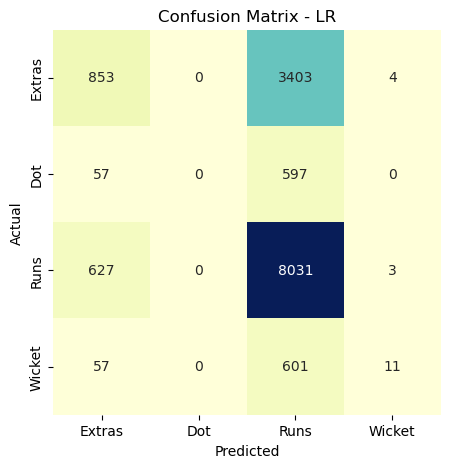

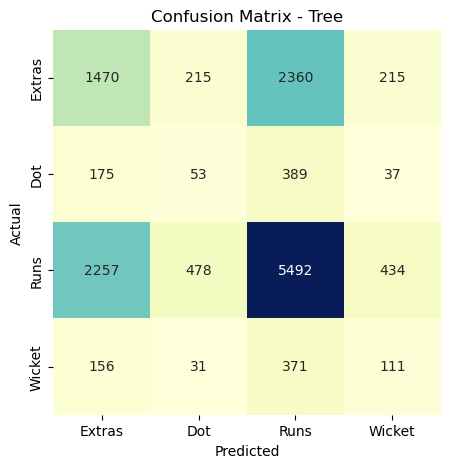

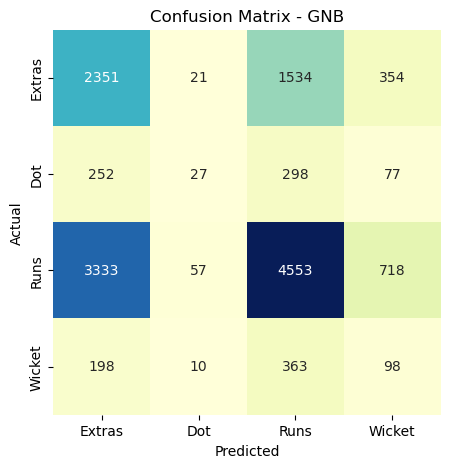

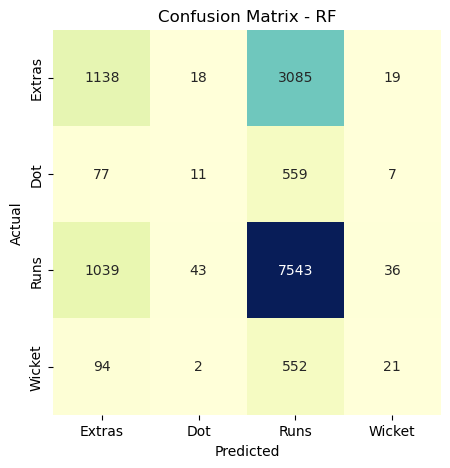

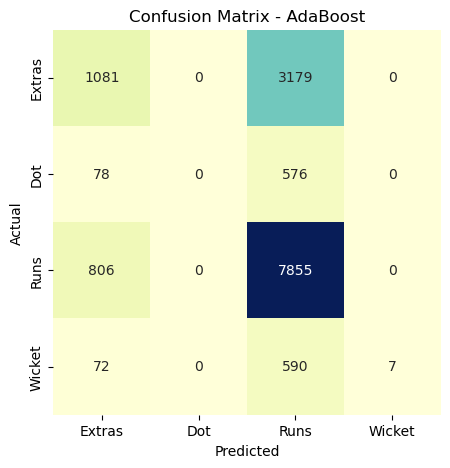

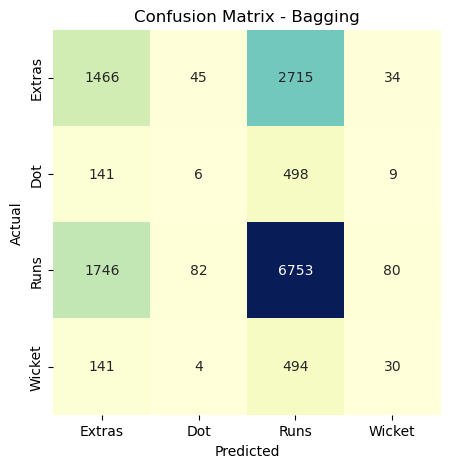

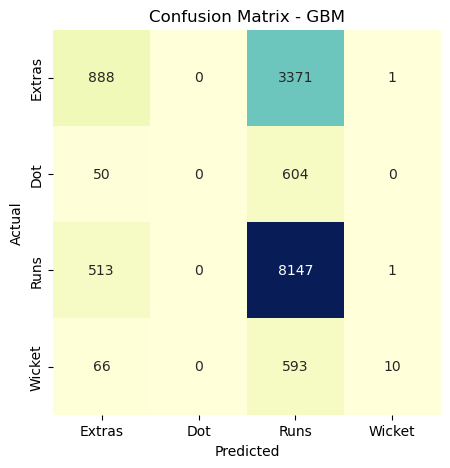

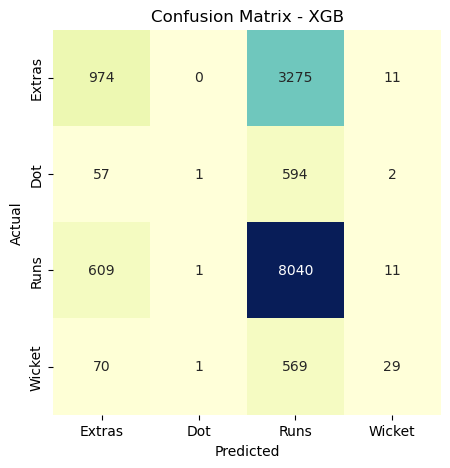

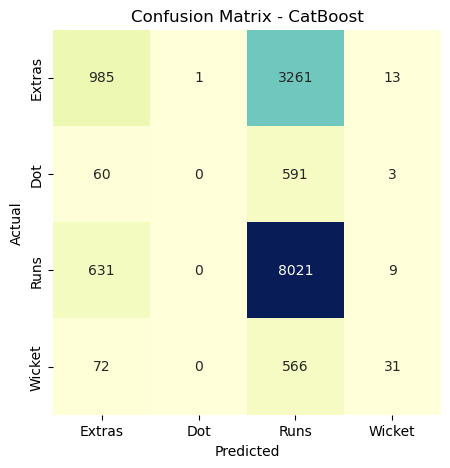

In [225]:
# Plot confusion matrices
for name, matrix in confusion_matrices.items():
    plt.figure(figsize=(5, 5))
    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="YlGnBu",
        cbar=False,
        xticklabels=["Extras", "Dot", "Runs", "Wicket"],
        yticklabels=["Extras", "Dot", "Runs", "Wicket"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.savefig(f"products/plots/confusion_matrix_{name}.png")
    plt.show()

In our multi-class classification project of predicting ball outcomes in cricket, we evaluated several algorithms, including boosting  (Adaboost, XGBoost, Gradient Boosting, and CatBoost), Gaussian Naive Bayes, Logistic Regression, and Decision Trees. Each of these algorithms exhibit unique strengths and weaknesses, and the choice between them involves striking a balance between different aspects of performance that are discussed below.

**Accuracy vs. Precision and Recall**:

Accuracy, while an essential metric, might not be the sole measure of a model's effectiveness, especially in this imbalanced dataset, where two classes, Extras and Runs, significantly outnumber the others, Dots and Wickets. As can be seen from the confusion matrices above, majority classes dominate the accuracy metric, leading to a misrespresentative view of holistic model performance. In cricket, especially in the scenario of betting, correctly predicting the minority class, Wickets, is of paramount importance.

Precision and recall are crucial metrics in such cases. Precision measures the accuracy of positive predictions, while recall gauges the model's ability to find all the relevant cases in a dataset. From the confusion matrices, we observed that Naive Bayes and Decision Tree (DTree) models exhibited better precision and recall for minority classes. This means that when these models predict a wicket or a boundary ball, they are more likely to be correct. In a business or real-world setting, this could translate to better decision-making and assist organizations that are trying to track illegal betting activity.

**Assessing Trade-Offs and Choosing the Right Model**:

Machine learning models often involve trade-offs. Boosting algorithms, while achieving high overall accuracy and weighted F1 scores, might sometimes sacrifice precision and recall for minority classes in favor of generalizing patterns across the majority class. On the other hand, Naive Bayes and Decision Tree models, being less complex, can capture intricate details in minority classes but might not generalize as well on the majority class.

Therefore, choosing the right model depends on the specific objectives of our prediction task and, eventually, the user who will be utilizing our deployed application. If the focus is on correctly identifying wickets and boundary balls, we might prioritize models like Naive Bayes or Decision Trees. However, if a more balanced performance across all classes is desired, as showcased by Weighted F1-Score, the boosting algorithms could be a better choice.

**Next Steps**:

Next, we shall implement a simple `LGBMClassifier` to see if we can improve the performance of our models. We shall also try tuning the parameters of selected boosting models using `RandomizedSearchCV` to obtain better generalization performance on the minority classes. Fianlly, we will build a stacked classifier with Naive Bayes and Decision Tree as the base estimators and CatBoost as the meta-estimator. We shall then compare the performance of these models with the ones we have already built.

## LightGBM Experiment 

In [176]:
from sklearn.metrics import accuracy_score, f1_score
from lightgbm import LGBMClassifier

LGBM = LGBMClassifier()

LGBM.fit(X_train, y_train)

y_pred = LGBM.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))

print("Weighted F1 Score: ", f1_score(y_test, y_pred, average="weighted"))

print("Classification Report: \n", classification_report(y_test, y_pred))

print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 489
[LightGBM] [Info] Number of data points in the train set: 117757, number of used features: 54
[LightGBM] [Info] Start training from score -1.196053
[LightGBM] [Info] Start training from score -2.908271
[LightGBM] [Info] Start training from score -0.521043
[LightGBM] [Info] Start training from score -3.013009
Accuracy Score:  0.6345127773097444
Weighted F1 Score:  0.5581512338764404
Classification Report: 
               precision    recall  f1-score   support

           0       0.58      0.21      0.31      4260
           1       0.00      0.00      0.00       654
           2       0.64      0.94      0.76      8661
           3       0.73      0.04      0.08       669

    accuracy                           0.63     14244
   ma

c:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# Hyperparameter Tuning With `RandomizedSearchCV`

## XGBoost

In [118]:
# defining parameter range
param_search = {
    #'max_depth': [2, 5, 10, 20],
    #'max_leaves': [0, 1, 3, 5],
    "learning_rate": [1, 0.1, 0.01],
    #'n_estimators': [50, 100],
    "booster": ["gbtree", "gblinear", "dart"],
    "gamma": [0, 0.5, 2, 5],
    #'min_child_weight': [0, 1, 3, 5],
}

search = RandomizedSearchCV(
    XGBClassifier(verbosity=0),
    param_search,
    refit=True,
    verbose=0,
    n_iter=25,
    scoring="f1_weighted",
    cv=5,
    n_jobs=-1,
)

search.fit(X_train, y_train)

# print best parameter after tuning
print("The best parameters after tuning are: ", search.best_params_)

# print how our model looks after hyper-parameter tuning
print("The best model after tuning looks like: ", search.best_estimator_)

# Save to file in the current working directory
pkl_filename = "products/pickle_files/XGB_Rand_Tuned.pkl"
with open(pkl_filename, "wb") as file:
    pickle.dump(search, file)

# Load from file
with open(pkl_filename, "rb") as file:
    pickle_model = pickle.load(file)
    score = pickle_model.score(X_test, y_test)
    print("Grid-Search Tuned XGBoost Test Set Accuracy: {0:.2f} %".format(100 * score))
    search_predictions = pickle_model.predict(X_test)

/Users/Tegveer/miniforge3/envs/ANLY501/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



The best parameters after tuning are:  {'learning_rate': 1, 'gamma': 2, 'booster': 'dart'}
The best model after tuning looks like:  XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
Grid-Search Tuned XGBoost Test Set Accuracy: 55.88 %


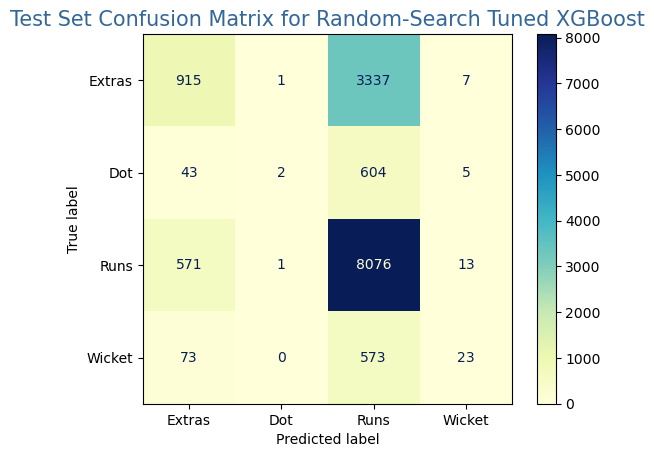

In [121]:
conf_matrix = confusion_matrix(y_test, search_predictions)
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=["Extras", "Dot", "Runs", "Wicket"],
)

# save the plot

disp.plot(cmap="YlGnBu", values_format="d", ax=None)
plt.title(
    "Test Set Confusion Matrix for Random-Search Tuned XGBoost",
    fontsize=15,
    color="#336699",
    loc="center",
)
plt.savefig("products/plots/confusion_matrix_XGB_Rand_Tuned.png")

## AdaBoost

In [128]:
# defining parameter range
param_search = {
    "learning_rate": [1, 0.1, 0.01],
    "n_estimators": [50, 100, 200],
    "estimator": [DecisionTreeClassifier(), Sup],
}

search = RandomizedSearchCV(
    AdaBoostClassifier(),
    param_search,
    refit=True,
    verbose=0,
    n_iter=25,
    scoring="f1_weighted",
    cv=5,
    n_jobs=-1,
)

search.fit(X_train, y_train)

# print best parameter after tuning
print("The best parameters after tuning are: ", search.best_params_)

# print how our model looks after hyper-parameter tuning
print("The best model after tuning looks like: ", search.best_estimator_)

# Save to file in the current working directory
pkl_filename = "products/pickle_files/Ada_Rand_Tuned.pkl"
with open(pkl_filename, "wb") as file:
    pickle.dump(search, file)

# Load from file
with open(pkl_filename, "rb") as file:
    pickle_model = pickle.load(file)
    score = pickle_model.score(X_test, y_test)
    print("Grid-Search Tuned XGBoost Test Set Accuracy: {0:.2f} %".format(100 * score))
    search_predictions = pickle_model.predict(X_test)

/Users/Tegveer/miniforge3/envs/ANLY501/lib/python3.9/site-packages/sklearn/model_selection/_search.py:307: UserWarning:

The total space of parameters 1 is smaller than n_iter=25. Running 1 iterations. For exhaustive searches, use GridSearchCV.



The best parameters after tuning are:  {'n_estimators': 500, 'learning_rate': 1}
The best model after tuning looks like:  AdaBoostClassifier(learning_rate=1, n_estimators=500)
Grid-Search Tuned XGBoost Test Set Accuracy: 55.67 %


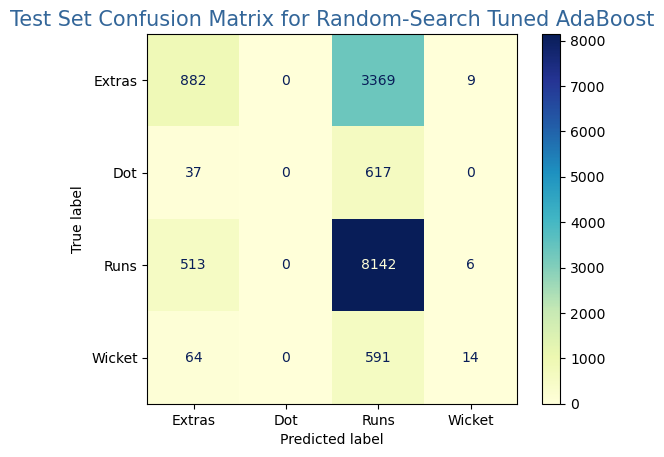

In [140]:
conf_matrix = confusion_matrix(y_test, search_predictions)
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=["Extras", "Dot", "Runs", "Wicket"],
)

# save the plot

disp.plot(cmap="YlGnBu", values_format="d", ax=None)
plt.title(
    "Test Set Confusion Matrix for Random-Search Tuned AdaBoost",
    fontsize=15,
    color="#336699",
    loc="center",
)
plt.savefig("products/plots/confusion_matrix_Ada_Rand_Tuned.png")

In [ ]:
# remove all pickle files for smooth git push

for name, model in models.items():
    pkl_filename = f"products/pickle_files/{name}.pkl"
    os.remove(pkl_filename)

Hyperparameter tuning, unfortunately, resulted in worse performing models. The default parameters of the boosting algorithms seem to be the best fit for our data. Let's now build a `StackingClassifier` with Naive Bayes and Decision Tree as the base estimators and CatBoost as the meta-estimator.

# Creating The Stacked Classifier

In [153]:
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(("GNB", GaussianNB()))
    level0.append(("Tree", DecisionTreeClassifier()))
    # define meta learner model

    level1 = CatBoostClassifier(verbose=0)

    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=10)

    return model


def base_models():
    models = dict()
    models["GNB"] = GaussianNB()
    models["Tree"] = DecisionTreeClassifier()
    models["XGB"] = XGBClassifier(verbosity=0)
    models["Stacked Model"] = get_stacking()
    return models


# Function to evaluate the list of models
def eval_models(model):
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
    accuracy = cross_val_score(
        model,
        X_train,
        y_train,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        error_score="raise",
    )
    weighted_f1 = cross_val_score(
        model,
        X_train,
        y_train,
        scoring="f1_weighted",
        cv=cv,
        n_jobs=-1,
        error_score="raise",
    )
    return accuracy, weighted_f1

In [154]:
%%time

models = base_models()
# evaluate the models and store results
results = {}
names = list()
accuracies = []
weighted_f1s = []

for name, model in models.items():
    accuracy, weighted_f1 = eval_models(model)
    accuracies.extend(accuracy)
    weighted_f1s.extend(weighted_f1)
    names.extend([name] * len(accuracy))
    print(
        ">%s Accuracy: %.3f Weighted F1: %.3f"
        % (name, accuracy.mean(), weighted_f1.mean())
    )

>GNB Accuracy: 0.483 Weighted F1: 0.493
>Tree Accuracy: 0.491 Weighted F1: 0.494
>XGB Accuracy: 0.622 Weighted F1: 0.553


/Users/Tegveer/miniforge3/envs/ANLY501/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Tegveer/miniforge3/envs/ANLY501/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Tegveer/miniforge3/envs/ANLY501/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Tegveer/miniforge3/envs/ANLY501/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWar

>Stacked Model Accuracy: 0.597 Weighted F1: 0.507
CPU times: user 630 ms, sys: 460 ms, total: 1.09 s
Wall time: 3min 11s


/Users/Tegveer/miniforge3/envs/ANLY501/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Store Results 

In [158]:
results["Model"] = names
results["Accuracy"] = accuracies
results["Weighted_F1"] = weighted_f1s

classifmod1 = pd.DataFrame(results)

## Visualize Train Set Accuracies

In [159]:
fig = px.box(
    classifmod1,
    x="Model",
    y="Accuracy",
    color="Model",
    points="all",
    labels={"Model": "Machine Learning Model", "Accuracy": "Accuracy"},
    title="Model Accuracy Performance",
)
fig.show()
fig.write_html("products/plots/stacked_train_accuracies.html")

## Visualize Train Set Weighted f1-Scores

In [160]:
fig = px.box(
    classifmod1,
    x="Model",
    y="Weighted_F1",
    color="Model",
    points="all",
    labels={"Model": "Machine Learning Model", "Weighted_F1": "Weighted f1-Score"},
    title="Model Weighted f1-Score Performance",
)
fig.show()
fig.write_html("products/plots/stacked_train_weighted_f1.html")

## Pickle Stacked Classifier

In [147]:
import pickle

level0 = list()
level0.append(("GNB", GaussianNB()))
level0.append(("Tree", DecisionTreeClassifier()))
level1 = XGBClassifier(verbosity=0)
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
model.fit(X_train, y_train)

# Save to file in the current working directory
pkl_filename = "products/pickle_files/stacked.pkl"
with open(pkl_filename, "wb") as file:
    pickle.dump(model, file)

# Load from file
with open(pkl_filename, "rb") as file:
    pickle_model = pickle.load(file)
    score = pickle_model.score(X_test, y_test)
    print("Test score: {0:.2f} %".format(100 * score))
    Y_predict = pickle_model.predict(X_test)

Test score: 61.12 %


## Test Set Confusion Matrix for Stacked Classifier

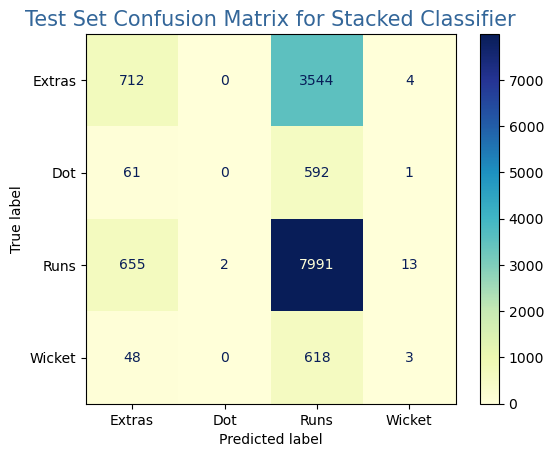

In [149]:
from sklearn.metrics import ConfusionMatrixDisplay
from seaborn import set_palette

conf_matrix = confusion_matrix(y_test, Y_predict)
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=["Extras", "Dot", "Runs", "Wicket"],
)

# save the plot

disp.plot(cmap="YlGnBu", values_format="d", ax=None)
plt.title(
    "Test Set Confusion Matrix for Stacked Classifier",
    fontsize=15,
    color="#336699",
    loc="center",
)
plt.savefig("products/plots/confusion_matrix_stacked.png")

# XGBoost, Naive Bayes, Tree Pickle Files for Deployment

## Preprocess Training Data Only 

In [ ]:
# split the dataset into train and test sets by season
train = df

# drop `season` column from train and test sets
train.drop(labels="season", axis=1, inplace=True)

encoded_df_train = pd.get_dummies(
    data=train,
    columns=[
        "match_type",
        "venue",
        "inning",
        "batting_team",
        "bowling_team",
        "batsman",
        "non_striker",
        "bowler_type",
        "ball_length",
    ],
)

encoded_df_train = encoded_df_train[
    [
        "ball",
        "wickets",
        "cumulative_runs",
        "match_type_playoffs",
        "match_type_round-robin",
        "venue_Ahmedabad",
        "venue_Bangalore",
        "venue_Chennai",
        "venue_Cuttack",
        "venue_Delhi",
        "venue_Dharamsala",
        "venue_Hyderabad",
        "venue_Indore",
        "venue_Kolkata",
        "venue_Mohali",
        "venue_Mumbai",
        "venue_Nagpur",
        "venue_Pune",
        "venue_Raipur",
        "venue_Rajasthan",
        "venue_Ranchi",
        "venue_Visakhapatnam",
        "inning_1",
        "inning_2",
        "batting_team_Chennai Super Kings",
        "batting_team_Delhi Capitals",
        "batting_team_Kings XI Punjab",
        "batting_team_Kolkata Knight Riders",
        "batting_team_Mumbai Indians",
        "batting_team_Rajasthan Royals",
        "batting_team_Royal Challengers Bangalore",
        "batting_team_Sunrisers Hyderabad",
        "bowling_team_Chennai Super Kings",
        "bowling_team_Delhi Capitals",
        "bowling_team_Kings XI Punjab",
        "bowling_team_Kolkata Knight Riders",
        "bowling_team_Mumbai Indians",
        "bowling_team_Rajasthan Royals",
        "bowling_team_Royal Challengers Bangalore",
        "bowling_team_Sunrisers Hyderabad",
        "batsman_top",
        "batsman_middle",
        "batsman_tail",
        "non_striker_middle",
        "non_striker_tail",
        "non_striker_top",
        "bowler_type_pacer",
        "bowler_type_spinner",
        "ball_length_Unknown",
        "ball_length_full",
        "ball_length_full toss",
        "ball_length_good",
        "ball_length_short",
        "ball_length_yorker",
        "event",
    ]
]

X_train = encoded_df_train.iloc[:, :-1].values

y_train = encoded_df_train.iloc[:, -1].values

encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)

y_train = y_train.reshape(
    len(y_train),
)

## Perform `RepeatedKFold` Classification Routine

In [ ]:
%%time

from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import DataConversionWarning
from tqdm import tqdm  # Import tqdm
# Assuming other necessary imports like LogisticRegression, DecisionTreeClassifier, etc., are already made

ConvergenceWarning('ignore')
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

def base_models():
    models = dict()
    models["Tree"] = DecisionTreeClassifier()
    models["GNB"] = GaussianNB()
    models["XGB"] = XGBClassifier(verbosity=0)
    return models

# Function to evaluate the list of models
def eval_models(model):
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
    accuracy = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    weighted_f1 = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise')
    return accuracy, weighted_f1

models = base_models()

# evaluate the models and store results
results = {}
names = list()
accuracies = []
weighted_f1s = []

final_models = {}  # Create a dictionary to store the fitted models

for name, model in tqdm(models.items()):  # Wrap models.items() with tqdm to get a progress bar
    accuracy, weighted_f1 = eval_models(model)
    accuracies.extend(accuracy)
    weighted_f1s.extend(weighted_f1)
    names.extend([name] * len(accuracy))
    print('>%s Accuracy: %.3f Weighted F1: %.3f' % (name, accuracy.mean(), weighted_f1.mean()))

    # Fit the model with the training data
    fitted_model = model.fit(X_train, y_train)

    # Save the fitted model as a pickle file
    pkl_filename = f"products/pickle_files/{name}_deploy.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(fitted_model, file)

# Store the fitted model in the final_models dictionary
    final_models[name] = fitted_model